In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import math

In [3]:
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn

In [4]:
class InputEmbeddings(nn.Module):
    model_dimension : int
    vocab_size : int

    def setup(self):
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.model_dimension)
    
    def __call__(self, x):
        x = self.embedding(x) * math.sqrt(self.model_dimension)
        return x

In [ ]:
class PositionalEncodings(nn.Module):
    model_dimension : int
    seq_len : int

    def setup(self):
        zeros = jnp.zeros((self.seq_len, self.model_dimension))
        row = jnp.arange(0, self.seq_len, 1)
        pos_matrix = row.reshape(-1, 1)
        row2 = jnp.arange(0, self.model_dimension, 1)
        pos2 = zeros + row2
        j = pos2 // 2
        denom = 1/(10000 ** ((2*j)/self.model_dimension))
        inp = pos_matrix * denom
        pi2j = jnp.sin(inp)
        pi2j1 = jnp.cos(inp)
        zeros = zeros.at[:, 0::2].set(pi2j[:, ::2])
        zeros = zeros.at[:, 1::2].set(pi2j1[:, 1: :2])
        
    def __call__(self, x):
        
         
        return x + self.encodings

In [50]:
class ScaledDotProduct(nn.Module):
    dk : int 

    def setup(self):
        self.W = nn.Dense(features=3*self.dk)

    def __call__(self, x):
        qkv = self.W(x)
        q,k,v = jnp.split(qkv, 3, axis=-1)
        weights = jnp.einsum('b t c, b T c -> b t T', q, k) / math.sqrt(self.dk)
        size = weights.shape[-1]
        mask = jnp.tril(jnp.ones((size, size)))
        logits = jnp.where(mask == 0, -9e15, weights)
        attention = nn.softmax(logits, axis=-1)
        values = jnp.einsum('b t T, b T c -> b t c', attention, v)
        return values

In [51]:
class MultiHeadAttention(nn.Module):
    n_heads :int 
    model_dim : int

    def setup(self):
        self.dk = self.model_dim / self.n_heads
        self.SA_layers = [ScaledDotProduct(self.dk) for i in range(self.n_heads)]
        self.WO = nn.Dense(features=self.model_dim)

    def __call__(self, x):
        scores = [layer(x) for layer in self.SA_layers] 
        mha = jnp.concatenate(scores, axis=-1)
        res = self.WO(mha)
        return res

In [ ]:
class LayerNorm(nn.Module):
    

In [52]:
class FeedForward(nn.Module):
    model_dimension : int
    ff_dim : int
    dropout : float

    def setup(self):
        self.linear1 = nn.Dense(features=self.ff_dim)
        self.linear2 = nn.Dense(features=self.model_dimension) 
    
    def __call__(self, x):
        x = self.linear1(x)
        x = nn.relu(x)
        x = self.linear2(x)
        x = nn.relu(x)
        return x

In [ ]:
#einsum version
#defining single head of attention
def ScaledDotProduct(q, k, v):
    dk = q.shape[-1]
    weights = jnp.einsum('b t c, b T c -> b t T', q, k) / math.sqrt(dk)
    size = weights.shape[-1]
    mask = jnp.tril(jnp.ones((size, size)))
    logits = jnp.where(mask == 0, -9e15, weights)
    attention = nn.softmax(logits, axis=-1)
    values = jnp.einsum('b t T, b T c -> b t c', attention, v)
    return values 


#defining single head of attention
def ScaledDotProduct(q, k, v):
    dk = q.shape[-1]
    kT = jnp.transpose(k, (0, 2, 1))
    weights = jnp.matmul(q, kT)
    size = weights.shape[-1]
    weights = weights/math.sqrt(dk)
    mask = jnp.tril(jnp.ones((size, size)))
    logits = jnp.where(mask == 0, -9e15, weights)
    attention = nn.softmax(logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values 



0 0
0 1
0 2
1 0
1 1
1 2


In [54]:
encodings = jnp.zeros((2, 3))

In [145]:
a = [1,2,3]

T = 256
d = 512

zeros = jnp.zeros((T,d))
row = jnp.arange(0, T, 1)
pos_matrix = row.reshape(-1, 1)
row2 = jnp.arange(0, d, 1)
pos2 = zeros + row2
j = pos2 // 2
denom = 1/(10000 ** ((2*j)/d))
inp = pos_matrix * denom
pi2j = jnp.sin(inp)
pi2j1 = jnp.cos(inp)
zeros = zeros.at[:, 0::2].set(pi2j[:, ::2])
zeros = zeros.at[:, 1::2].set(pi2j1[:, 1: :2])

In [ ]:
time = jnp.arange(0, T)
d_test = jnp.arange(0, d//2)
angular =  1/(10000 ** (2 * (d_test)/d))
theta = time[:, None] * angular[None, :]
sin = jnp.sin(theta)
cos = jnp.cos(theta)

ans = jnp.stack([sin, cos], axis=-1).reshape(T, -1)
ans.shape

(256, 512)

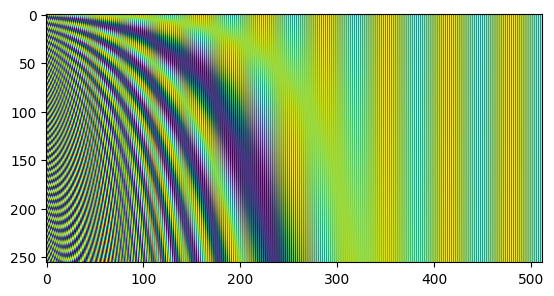

In [147]:
import matplotlib.pyplot as plt
plt.imshow(zeros)